# Introduction

The first project that you will complete this semester is to design, implement, and test a controller that uses a single-gimbal control moment gyroscope (CMG) to reorient a platform in a gravitational field, as pictured below:

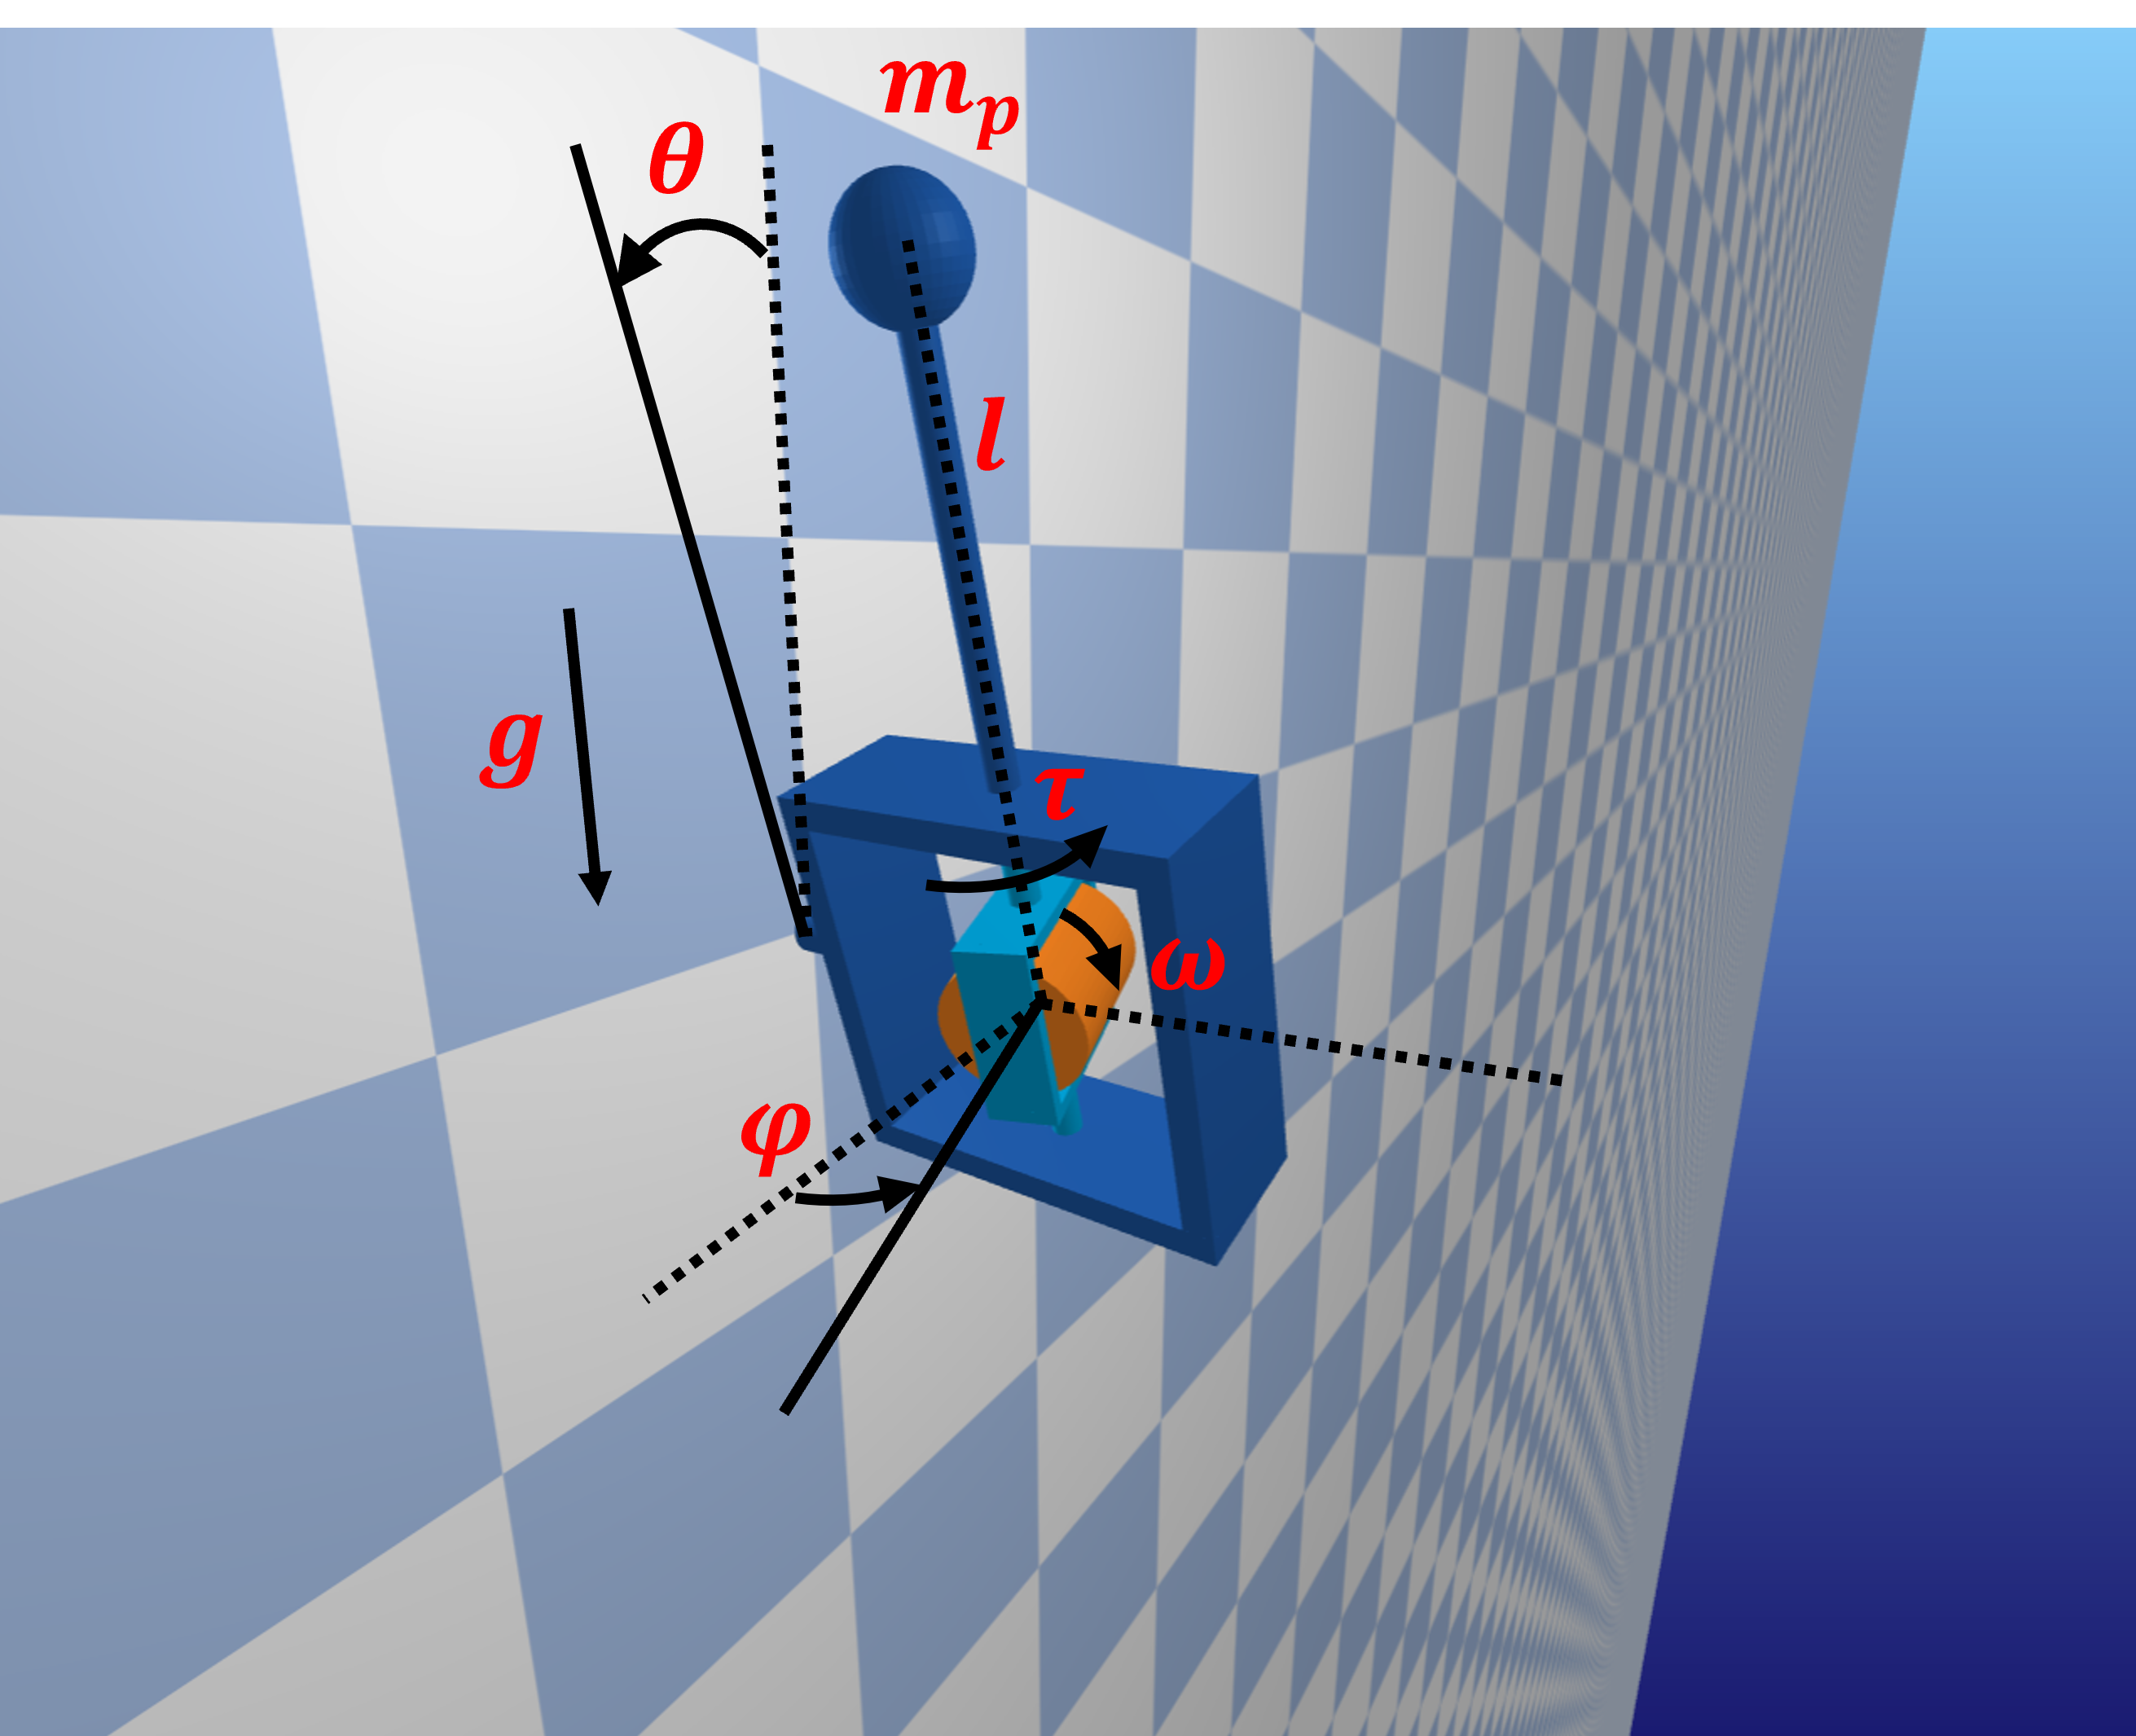

This system has three parts:
* A frame (dark blue) that can rotate freely about its axle through angle $\theta$. Think of this as a spacecraft that is confined to rotate about its pitch axis, as if it were being tested on the ground.
* A cage, or gimbal, (light blue) that can be driven by a motor to rotate about a perpendicular axis with respect to the frame through angle $\phi$.
* A cylinder, or rotor, (orange) that can be driven by a motor to spin about yet another perpendicular axis with respect to the gimbal.

The input to the system is some torque, $\tau$, that is applied to the gimbal causing it to rotate through angle $\phi$. Gravity, $g$, is acting directly downward. Whereas it is not intuitive, we will find that this torque can result in changes to both $\phi$ and, through the conservation of momentum, $\theta$.

# Context

Reaction wheels and control-moment gyroscopes (CMGs) are two different non-propulsive actuators (i.e., actuators that do not consume fuel) that are commonly used to control the attitude of spacecraft.

A reaction wheel spins at a variable rate about an axis that is fixed with respect to the spacecraft. If the spacecraft applies a torque to this wheel with a motor (either speeding it up or slowing it down), then an equal and opposite torque is applied to the spacecraft.

A single-gimbal CMG also has a spinning wheel, but with two key differences: (1) the wheel spins at a constant rate instead of at a variable rate, and (2) the wheel is held by a gimbal that allows the axis of spin to be tilted with respect to the spaceraft instead of staying fixed.

In particular, if the wheel in a single-gimbal CMG — often called a rotor — is spun at a high rate, then an “input torque” applied to the gimbal will, through conservation of angular momentum, result in an “output torque” applied to the platform about an axis perpendicular both to the gimbal axis and the rotor axis.

One advantage of using a single-gimbal CMG over a reaction wheel is that this output torque can be much higher than the input torque — a so-called “torque amplification” effect. That is to say, CMGs have the ability to generate large torques with relatively low power consumption. This makes them well-suited for long-duration space missions — including geosynchronous satellites and interplanetary probes — where power and weight constraints are significant considerations. This also means that CMGs can, in general, produce much larger torques than reaction wheels, which can be useful for attitude control of very large spacecraft. The International Space Station (ISS) is one example of a large spacecraft whose attitude is controlled by CMGs — here is an image of a CMG being installed on ISS by an STS-118 crew member:

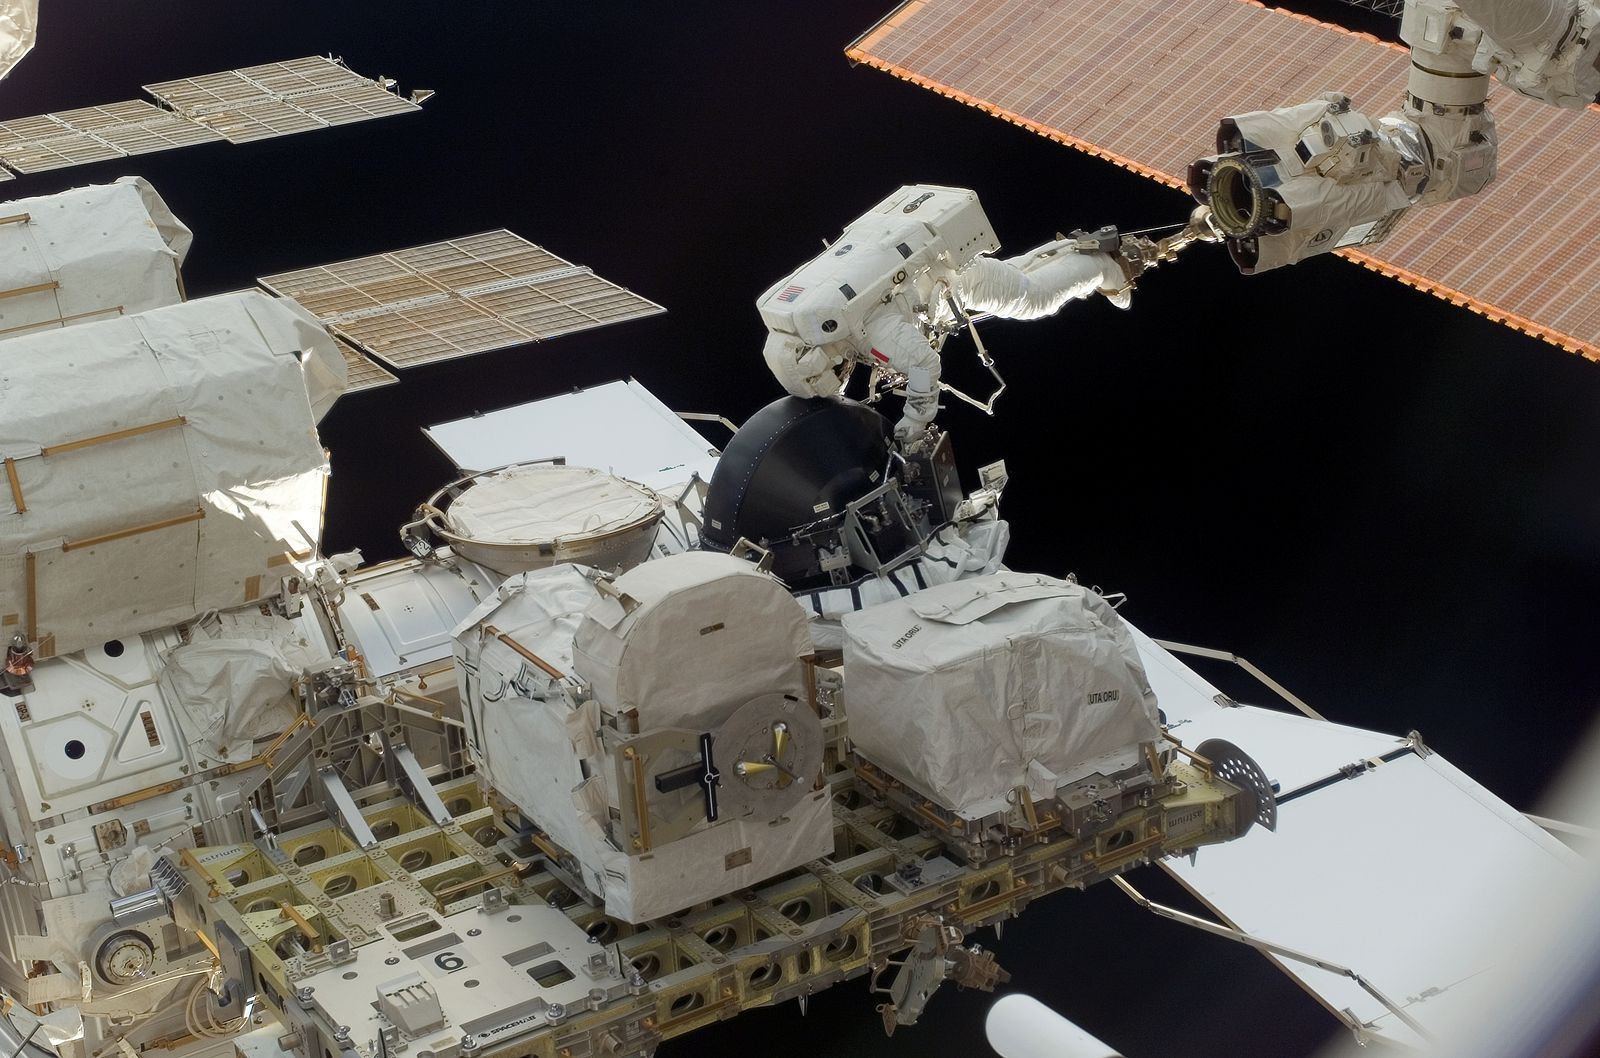

ISS uses four double-gimbal CMGs rather than the one single-gimbal CMG you will be considering in this project, although the principles of operation are similar. These CMGs have a life expectency of about 10 years, contain a rotor that spins at 691 rad/s (6600 rpm), and can produce an output torque of 258 N-m (190 ft-lbf). The orientation of ISS can be fine-tuned to point exactly at a target By controlling the tilt of each CMG.

There are disadvantages to using CMGs instead of reaction wheels, of course. One disadvantage, for example, is that the dynamics of a CMG are more complicated than those of a reaction wheel and require a more sophisticated controller.

This first design project will familiarize you with the operational concepts and physics behind the use of CMGs on modern spacecraft, and in particular will give you a sense of what it takes to control them.

You can read more about CMGs and their use for spacecraft attitude control in [Fundamentals of Spacecraft Attitude Determination and Control (Markley and Crassidis, 2014)](https://link.springer.com/book/10.1007/978-1-4939-0802-8).

# System Dynamics and Equations of Motion

The first step we will take will be to derive the equations of motion of the system. As usual, the first step in the Lagrangian mechanics approach is to calculate the total kinetic energy of the system and the total potential energy of the system with respect to the generalized coordinates and their derivatives. We can do this using the Python package Sympy.

In [ ]:
# Import everything we need from SymPy
import sympy as sym
import numpy as np
from sympy import Symbol, Matrix, Function, Derivative, N
from sympy import diff, simplify, sin, cos, solve, init_printing, symbols
init_printing() # This function will make the outputs of SymPy look prettier and be easier to read

Now we are going to define the parameters of the system as constants:

In [ ]:
# Constants of the system
mp = 0.5      # Mass of the sphere on the top of the frame
ixx = 0.03    # Lateral mass moment of inertia of the gimbal
izz = 0.04    # Longitudinal mass moment of inertia of the gimbal
l = 1.5       # Distance from the center of the gimbal to the center of the sphere on top of the frame
g = 9.81      # Acceleration due to gravity
rotor_velocity = 100.0 # Fixed angular rate of the gimbal in rad/sec

Now we make symbols and functions. These are elements of SymPy and can be thought of as exactly the same as symbols (variables) and functions from math.

In [ ]:
# Time is a symbol (variable)
t = Symbol('t')

# The generalized coordinates and the input torque are both functions of time.
# This means that they are initialized as Functions.
theta = Function('theta')
phi = Function('phi')
tau = Function('tau')

Now we will start to calculate the energies of the system. We can start by getting the kinetic energy of the mass on top of the frame. We can do this by:
1. Defining its position in terms of the generalized coordinates
2. Take the derivate of the position with respect to time to get the velocity
3. Calculate the kinetic energy from the velocity
4. Calculate the potential energy by observation

In [ ]:
# Get the position of the mass
pos = Matrix([-l*sin(theta(t)),
              0.0,
              l*cos(theta(t))])

In [ ]:
# Take the derivative of position with respect to time
vel = diff(pos,t)

In [ ]:
# Get the kinetic energy of the mass from the velocity
mass_KE = 0.5 * mp * (vel.T @ vel)[0,0]

In [ ]:
# Get the potential energy of the mass based on its position
mass_PE = mp*g*l*cos(theta(t))

No other parts of the frame or gimbal cage have inertia or mass. This means the only other component that has energy is the gimbal itself. Because it's center of mass doesn't change altitude and is at the origin, the only energy it has is rotational energy. We will calculate that now.

In [ ]:
# The is the rotational rate of the gimbal
gimbal_rate = Matrix([Derivative(phi(t), t),
                      Derivative(theta(t), t)*cos(phi(t)),
                      rotor_velocity - Derivative(theta(t), t)*sin(phi(t))])

In [ ]:
# This is the mass moment of inertia of the gimbal
I = Matrix([[ixx, 0.0, 0.0],
            [0.0, ixx, 0.0],
            [0.0, 0.0, izz]])

In [ ]:
# Calculate the rotational energy of the gimbal
gimbal_RE = (0.5 * (gimbal_rate.T @ I @ gimbal_rate))[0, 0]

Now we calculate the lagrangian of the system via the formula:$$L=T-V$$ where $T$ is the total kinetic energy and $V$ is the total potential energy.

In [ ]:
# Get the lagrangian
L = (mass_KE + gimbal_RE) - mass_PE
print("System Lagrangian:")
L = simplify(L)
N(L, 3) # This rounds floating point number to 3 places and then prints to the screen

Finally, we get the equations of motion of the system via the formulas:
$$\frac{d}{dt} \left( \frac{\partial L}{\partial \dot{\theta}} \right) - \frac{\partial L}{\partial \theta}=0$$
$$\frac{d}{dt} \left( \frac{\partial L}{\partial \dot{\phi}} \right) - \frac{\partial L}{\partial \phi}=\tau$$

In [ ]:
# Get the first equation of motion
eq1 = diff(diff(L, Derivative(theta(t), t)), t) - diff(L, theta(t))

In [ ]:
# Get the second equation of motion
eq2 = diff(diff(L, Derivative(phi(t), t)), t) - diff(L, phi(t)) - tau(t)

This form of equations of motion is not very helpful to us right now, so next we will place them in standard form. A standard form system of ordinary differential equations satisfy the following requirements
* All equations are exactly first order ordinary differential equations
* Each equation only has exactly one time derivative variable in it
* Each equation has the form $\frac{d x}{dt} = f(x,y,z,...)$

Because the equations of motion above are second order, we need to apply a trick to place them in standard form. Namely, we introduce new variables that increase the number of equations while reducing the order of each equation. For example, let's introduce two new variables, $\omega_{\theta}$ and $\omega_{\phi}$ that satisfy the standard form ordinary differential equations:
$$\frac{d \theta}{dt} = \omega_{\theta}$$
$$\frac{d \phi}{dt} = \omega_{\phi}$$
Then, by taking the derivative of both sides, we see that
$$\frac{d^2 \theta}{d t^2} = \frac{d \omega_{\theta}}{dt}$$
$$\frac{d^2 \phi}{d t^2} = \frac{d \omega_{\phi}}{dt}$$
Let's make this change of variables to our equations of motion right now.

In [ ]:
# Make the new functions for change of variables
omega_theta = Function('omega_theta')
omega_phi = Function('omega_phi')

In [ ]:
# Make the change of variables for equation 1
eq1 = eq1.subs({Derivative(theta(t), (t, 2)) : Derivative(omega_theta(t), t), 
                Derivative(phi(t), (t, 2))   : Derivative(omega_phi(t), t),
                Derivative(theta(t), t)      : omega_theta(t),
                Derivative(phi(t), t)        : omega_phi(t)})

In [ ]:
# Repeat for equation 2
eq2 = eq2.subs({Derivative(theta(t), (t, 2)) : Derivative(omega_theta(t), t), 
                Derivative(phi(t), (t, 2))   : Derivative(omega_phi(t), t),
                Derivative(theta(t), t)      : omega_theta(t),
                Derivative(phi(t), t)        : omega_phi(t)})

The final step to place the equations in standard form is to ensure they have the form $\frac{d x}{dt} = f(x,y,z,...)$. We do this now.

In [ ]:
# Solve the equations for Derivative(omega_theta(t), t) and Derivative(omega_phi(t), t)
soln = solve([eq1, eq2],
              Derivative(omega_theta(t), t),
              Derivative(omega_phi(t), t))

We now have a system of ordinary differential equations in standard from. Specifically, we have:
$$\frac{d \omega_{\theta}}{dt} = f_{\omega_{\theta}}\left( \omega_{\theta}, \omega_{\phi}, \theta, \phi, \tau \right)$$
$$\frac{d \omega_{\phi}}{dt} = f_{\omega_{\phi}}\left( \omega_{\theta}, \omega_{\phi}, \theta, \phi, \tau \right)$$
$$\frac{d \theta}{dt} = f_{\theta}\left( \omega_{\theta}, \omega_{\phi}, \theta, \phi, \tau \right)$$
$$\frac{d \phi}{dt} = f_{\phi}\left( \omega_{\theta}, \omega_{\phi}, \theta, \phi, \tau \right)$$

Let's now combine the right hand side of this system into a single vector.

In [ ]:
# Build the equations of motion vector
f = Matrix([soln[Derivative(omega_theta(t), t)],
            soln[Derivative(omega_phi(t), t)],
            omega_theta(t),
            omega_phi(t)])

# Replace the functions of time with symbols
(v1, v2, v3, v4, v5) = symbols('v1, v2, v3, v4, v5')
f = f.subs({omega_theta(t) : v1,
            omega_phi(t) : v2,
            theta(t) : v3,
            phi(t) : v4,
            tau(t) : v5})
(omega_theta, omega_phi, theta, phi, tau) = symbols('omega_theta, omega_phi, theta, phi, tau')
f = f.subs({v1 : omega_theta,
            v2 : omega_phi,
            v3 : theta,
            v4 : phi,
            v5 : tau})

# Simplify
f = simplify(f)

$f$ is our system model such that
$$
\begin{bmatrix}
\dot{\omega}_{\theta} \\
\dot{\omega}_{\phi} \\
\dot{\theta} \\
\dot{\phi} \\
\end{bmatrix} = f(\omega_{\theta}, \omega_{\phi}, \theta, \phi, \tau)
$$

In [ ]:
N(f, 3)  # This rounds floating point number to 3 places and then prints to the screen

# FIXME: System Linearization and State Space Form

In [ ]:
# >>>>>FIXME>>>>> Place the system in standard form, linearize it, and calculate the A and B matrices.

# FIXME: Gain Selection and Controller Design

In [ ]:
# >>>>>FIXME<<<<<: Guess a gain matrix and ensure the closed-loop system is stable.

In [ ]:
# Create the Controller class
class Controller():
    def __init__(self):
        """
        Initializes the controller. You should initialize any member variables that
        the controller will use to their starting values. This function is called
        when a new instance of the Controller class is created.
    
        Parameters
        ----------
        None.
    
        Returns
        -------
        None.
        """
        # >>>>>FIXME<<<<<: Replace the following with your own __init__ function
        pass
    
    def reset(self):
        """
        Resets the controller to an initial state. You should reset any variables
        that track states, times, etc. in this function. This function will be 
        called just before the simulation starts running and any time the simulation
        is reset.
    
        Parameters
        ----------
        None.
    
        Returns
        -------
        None.
        """
        # >>>>>FIXME<<<<<: Replace the following your own reset function
        pass 

    
    def run(self, **kwargs):
        """
        Runs the controller. Data is passed from the simulation environment to the
        controller via kwargs, the controller calculates the inputs to the system,
        and then returns them via a return statement
    
        Parameters
        ----------
        **kwargs : Dictionary
            A dictionary of data passed from the simulation environment to the 
            controller. Specific data is extracted from kwargs via the statement:
            kwargs["KEYWORD"], where "KEYWORD" is a key to the dictionary. The keys
            of kwargs for this project are as follows:

            kwargs["frame_angle"] : Float
                The current angle of the frame in radians (theta)

            kwargs["gimbal_angle"] : Float
                The current target angle of the gimbal in radians (phi)

            kwargs["frame_velocity"] : Float
                The current angular velocity of the frame in radians/second

            kwargs["gimbal_velocity"] : Float
                The current angular velocity of the gimbal in radians/second

            kwargs["rotor_velocity"] : Float
                The current angular velocity of the rotor in radians/second

            kwargs["time"] : Float
                The current simulation time in seconds
            
    
        Returns
        -------
        inputs : List with length equal to the number of inputs
            This is a list of the inputs calculated by the controller. In this
            project, there is only one input, the torque to be applied to the 
            gimbal. Even though there is only one input in this project,
            it still must be placed in a list of length one.
        
        """
        # >>>>>FIXME<<<<<: Replace the following manual controller your own controller
        torque = 0.0
        if kwargs["sd"]:
            torque = torque + 0.5
        if kwargs["sa"]:
            torque = torque - 0.5
        if kwargs["d"]:
            torque = torque + 0.125
        if kwargs["a"]:
            torque = torque - 0.125
        
        # Return the manually set torque
        inputs = [torque]
        return inputs

In [ ]:
# Create an instance of our Controller class
controller = Controller()

# Running the simulation

Before we run the simulation, we must first import the simulation module and then create an instance of the simulator. This is done below:

In [ ]:
# Import the cmg project. This module is used to simulate, render, and plot the dynamic system
import ae353_cmg

In [ ]:
# Create an instance of the cart simulator
sim = ae353_cmg.CMG_sim(use_keyboard=True,
                        animation=False,
                        visualization=True)

Now we are ready to run the simulation and collect data. To do this we call the ``sim.run()`` function. This function takes an instance of the ``Controller`` class as an argument and returns ``data``. The parameters and return values of ``sim.run()`` are shown below.

#### Parameters

> **controller** : *member of Controller class*  
> Your controller that will generated inputs to the system.
> 
> **max_time** : *Float or None, optional*  
> The total amount of time the simulation is allowed to run. If set to None, the simulation will run until "ESC" is pressed on the keyboard. If the keyboard is disabled (Mac users), and max_time is set to None, the simulation will automatically terminate after 10 seconds of simulated time. The default value is None.
> 
> **initial_frame_angle** : *Float, optional*  
> The initial angle of the frame in radians. This is set when the simulation starts and when the simulation is reset. The default value is 0.0.
> 
> **initial_gimbal_angle** : *Float, optional*  
> The initial angle of the gimbal in radians. This is set when the simulation starts and when the simulation is reset. The default value is 0.0.
> 
> **initial_frame_velocity** : *Float, optional*  
> The initial velocity of the frame in radians/second. This is set when the simulation starts and when the simulation is reset. The default value is 0.0.
> 
> **initial_gimbal_velocity** : *Float, optional*  
> The initial velocity of the gimbal in radians/second. This is set when the simulation starts and when the simulation is reset. The default value is 0.0.
>
> **rotor_velocity** : *Float, optional*  
> The fixed velocity of the rotor. Remember, if this is changed, the dynamics will also be changed. Make sure to update your controller accordingly! The default value is 100.0.
>
> **frame_damping** : *Float, optional*
> The damping applied to the frame axle. If set to 0, no energy is lost. Anything greater than 0 results in energy loss while the frame is moving. The default value is 0.1.

#### Returns

> **data** : *Dictionary of Lists*  
> A dictionary containing all relevant data generated during the simulation. Specific data is extracted via the statement: data["KEYWORD"], where "KEYWORD" is a key to the dictionary. The keys of data for this project are as follows:
> 
> **data["frame_angle"]** : *List of Floats*  
> A list of the frame angle in radians at each time stamp during the simulation.
> 
> **data["gimbal_angle"]** : *List of Floats*  
> A list of the gimbal angle in radians at each time stamp during the simulation.
> 
> **data["frame_velocity"]** : *List of Floats*  
> A list of the frame velocity in radians/secondat each time stamp during the simulation.
> 
> **data["gimbal_velocity"]** : *List of Floats*  
> A list of the gimbal velocity in radians/second at each time stamp during the simulation.
>
> **data["rotor_velocity"]** : *List of Floats*  
> A list of the rotor velocity in radians/secondat each time stamp during the simulation.
> 
> **data["torque"]** : *List of Floats*  
> A list of the applied torque in Newton-meters at each time stamp during the simulation.
> 
> **data["time"]** : *List of Floats*  
> A list of the time stamps in seconds.

If enabled you can use the keyboard to interact with the simulation:  
* press **ENTER** to start the simulation
* press **BACKSPACE** to reset the simulation
* press **SPACE** to pause the simulation
* press **ESC** to end the simulation

If the manual controller is being used:
* press **a** to apply small negative torque to the gimbal
* press **SHIFT+a** to apply large negative torque to the gimbal
* press **d** to apply small positive torque to the gimbal
* press **SHIFT+d** to apply large positive torque to the gimbal 

In [ ]:
# Run the simulation and collect the simulation data
data = sim.run(controller,
               max_time = 10.0,
               initial_frame_angle = 0.0,
               initial_gimbal_angle = 0.0,
               initial_frame_velocity = 0.0,
               initial_gimbal_velocity = 0.0,
               rotor_velocity = rotor_velocity,
               frame_damping = 0.1)

# Post-processing the simulation data

After the simulation is run, we can plot the data using the Matplotlib package. To start, we import matplotlib.

In [ ]:
# Import the pyplot module from the matplotlib package
import matplotlib.pyplot as plt

Now we can make whichever plots we see fit to make sense of the simulation data. Here we plot the pendulum versus time as well as the applied torque versus time.

In [ ]:
# Create a figure that has two plots in it
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.4), sharex=True)

# Create a plot of the frame and gimbal angles versus time on the first plot
axes[0].plot(data['time'], data['frame_angle'], label="Frame", c='k', lw=2.5)
axes[0].plot(data['time'], data['gimbal_angle'], label="Gimbal", c='r', lw=2.5)
axes[0].set_ylabel("Angle [rad]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].legend(fontsize=12, shadow=True)
axes[0].set_title("State vs. Time", fontsize=14)
axes[0].grid()

# Create a plot of the torque versus time on the second plot
axes[1].plot(data['time'], data['torque'], label="Torque", c='b', lw=2.5)
axes[1].set_xlabel("Time [s]", fontsize=12)
axes[1].set_ylabel("Torque [Nm]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_title("Torque vs. Time", fontsize=14)
axes[1].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.show()